In [70]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import Image
import matplotlib.cm as cm

## What is phantom traffic jam?
 
A **Phantom Traffic Jam** is a spontaneous traffic stoppage that occurs without any visible cause (like an accident or construction).

It happens due to **instability** in high-density traffic:

**The Trigger**: One driver brakes slightly (due to a distraction or lane change).

**The Amplification**: Because of reaction time delays, the driver behind brakes a little harder to maintain safety. The third driver brakes even harder.

**The Shockwave**: This creates a wave of stopping cars that travels backward (upstream) through the traffic, often persisting long after the first car has accelerated away.

<div>
<center>
<img src="real_world_example.png" width="500"/>
</center>
</div>

In [71]:
def create_car(car_id, position, velocity):
    return {
        "id": car_id,
        "position": position,
        "velocity": velocity,
        "history_time": [],
        "history_vel": [],
        "history_pos": []
    }

def log_car_state(car, time):
    car["history_time"].append(time)
    car["history_vel"].append(car["velocity"])
    car["history_pos"].append(car["position"])

def generate_car(total_car, velocity):
    cars = []
    for i in range(total_car, 0, -1):
        pos = i * 15
        car = create_car(total_car - i, pos, velocity)
        cars.append(car)
    return cars

# Phantom Traffic Simulation

## 1. Intelligent Driver Model (IDM Model)

$$ a = a_{max} \left[ 1 - \left( \frac{v}{v_0} \right)^\delta - \left( \frac{s^*}{s} \right)^2 \right] $$

### What do the symbols mean?
*   **$a$ (Acceleration):** How much the driver presses the gas pedal (positive) or brake pedal (negative).
*   **$a_{max}$ (Max Acceleration):** The maximum power of the car's engine.
*   **$v$ (Current Speed):** How fast the car is going right now.
*   **$v_0$ (Desired Speed):** The speed limit or how fast the driver *wants* to go.
*   **$\delta$ (Delta):** How aggressively the driver accelerates when the road is open.
*   **$s$ (Actual Gap):** The real distance to the car in front.
*   **$s^*$ (Desired Gap):** The safe distance the driver *wants* to keep. If the real gap ($s$) is smaller than this ($s^*$), the driver brakes.

It simply returns the best acceleration ($a$) which prevent collision.

## 2. Predicting the Future: Solving ODEs with Simple Physics

### The Physics Foundation
Every moving car follows Newton's basic motion laws:
$$ \frac{dx}{dt} = v \quad \text{(Position changes at rate = velocity)} $$
$$ \frac{dv}{dt} = a \quad \text{(Velocity changes at rate = acceleration)} $$

### How We Solve These ODEs in Code
In simulation loop, these simple physics updates:
```python
# Update Velocity: v = v + at  (Euler step for dv/dt = a)
cur_car["velocity"] += safe_acc * h

# Update Position: x = x + vt  (Euler step for dx/dt = v) 
cur_car["position"] += cur_car["velocity"] * h
```

Each time step `h` moves the system forward by approximating. (smaller h  = more accurate)

Repeating these simple formulas thousands of times with tiny time steps. We use ODEs to predict the future traffic flow.

## 3. Accuracy & Computation Cost

*   **h value** - The time step `h` must be small enough to capture rapid changes in acceleration and velocity, ensuring accurate simulation of traffic dynamics. The smaller h the more accurate but also increases computation time.
*   **Computation Cost** - Depend on number of cars and simulation duration. More cars and longer times increase computation time significantly.

## 4. Why Phantom Jams Happen

A "phantom jam" is when traffic stops for no apparent reason (no accidents or roadworks).

In this model, it happens **only when drivers are aggressive**.
*   **Aggressive Behavior:** Driving fast, braking hard, and following too closely.
*   **The Chain Reaction:** If one aggressive driver taps the brakes, the car behind them panics and brakes harder. The next car brakes even harder.
*   **Result:** This "wave" of braking travels backward, eventually causing cars miles behind to come to a complete stop.

## 5. Limitation

*   **Parameter Dependencies** - How IDM parameters like reaction time T must be precisely tuned (T=2.0s works, T=1.5s doesn't)

*   **Road/Car Gap Issue** - If the gap between road length and car count is too large, the phantom jam effect can't propagate properly

*   **Velocity/Spacing Balance** - The relationship between max velocity (10 m/s) and initial car spacing (15m) must be well-proportioned for realistic following behavior

In [72]:
T = 2.0          
A_MAX = 0.5      
B_COMF = 3.0     
DELTA = 6        
S0 = 2.0        
MAX_BRAKING = -8.0 

def get_idm_acceleration(current_car, front_car, desired_velocity, road_length):
    cur_vel = current_car["velocity"]
    front_vel = front_car["velocity"]
    
    gap_vel = cur_vel - front_vel
    gap_pos = front_car["position"] - current_car["position"]


    if gap_pos < 0:
        gap_pos += road_length
    
    # Desired distance: s* = s₀ + vT + (vΔv)/(2√ab)
    s_star = S0 + max(0, cur_vel * T + (cur_vel * gap_vel) / (2 * np.sqrt(A_MAX * B_COMF)))
    
    safe_gap = max(gap_pos - 5.0, 0.1)
    
    velocity_term = (cur_vel / desired_velocity) ** DELTA  
    gap_term = (s_star / safe_gap) ** 2                   

    # Best acc: a = a_max[1 - (v/v₀)^δ - (s*/s)²]
    acc = A_MAX * (1 - velocity_term - gap_term)
    
    if gap_pos < 8.0:  
        acc = min(acc, -2.0)
    
    if gap_pos < 3.0:
        acc = MAX_BRAKING   
    
    acc = max(min(acc, A_MAX), MAX_BRAKING)
    return acc

## The Simulation Loop

**This iterative process transforms individual driver decisions into collective traffic behavior!**

**Core Process:** For each car at every time step:

1. Calculate acceleration using IDM (based on the car ahead). Repeat thousands of times to see traffic patterns emerge

2. Update velocity using physics: `v_new = v_old + a × time_step`

3. Update position using physics: `x_new = x_old + v_new × time_step`

In [73]:
def run_simulate(total_car, max_velocity, time_bound, h):
    # generate car
    cars = generate_car(total_car, max_velocity)    
    road_length = total_car * 16

    steps = int(time_bound / h)
    current_time = 0.0

    
    # Add more 10 seconds to stay on max velocity
    for _ in range(100):
        for car in cars:
            car["position"] += car["velocity"] * h
            
            if car["position"] >= road_length:
                car["position"] -= road_length
            log_car_state(car, current_time)
                
        current_time += h

    for _ in range(steps):    
        for i in range(len(cars)):    
            cur_car = cars[i]
            front_car = cars[(i - 1)% total_car]

            # front car detect last car
            if (cur_car["id"] == 0):
                front_car = cars[total_car - 1]
            

            if (10 < current_time < 20  and cur_car["id"] == 0):
                cur_car["velocity"] -= 0.7 * h
                if cur_car["velocity"] < 0:
                    cur_car["velocity"] = 0
                cur_car["position"] += cur_car["velocity"] * h
                log_car_state(cur_car, current_time)
                continue
            
            log_car_state(cur_car, current_time)
            # Get safe acceleration
            safe_acc = get_idm_acceleration(cur_car, front_car, max_velocity, road_length)

            # Update Velocity: v = v + at
            cur_car["velocity"] += safe_acc * h
            if cur_car["velocity"] > max_velocity:
                cur_car["velocity"] = max_velocity
            if cur_car["velocity"] < 0: 
                cur_car["velocity"] = 0 

            # Update Position: x = x + vt
            cur_car["position"] += cur_car["velocity"] * h
            
            if cur_car["position"] >= road_length:
                cur_car["position"] -= road_length
        
        current_time += h

    return cars, road_length

In [74]:
def animate_combined_view(cars, road_length, filename="phantom_simulation.gif"):
    # Get time range and data
    max_time = max([car["history_time"][-1] for car in cars])
    all_times = cars[0]["history_time"]
    
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Phantom Traffic Jam: Real-time Analysis', fontsize=16, fontweight='bold')
    
    # === LEFT PLOT: Velocity Evolution ===
    lines = []
    colors = cm.Set3(np.linspace(0, 1, len(cars)))
    
    for i, car in enumerate(cars):
        if car["id"] == 0:
            line, = ax1.plot([], [], linewidth=3, color='black', linestyle='--', 
                           label=f'Car {car["id"]+1} (Lead)', alpha=0.9)
        else:
            line, = ax1.plot([], [], color=colors[i], alpha=0.7, 
                           label=f'Car {car["id"]+1}')
        lines.append(line)
    
    # Set up velocity plot
    ax1.set_xlim(0, max_time)
    ax1.set_ylim(-0.5, 10)
    ax1.set_xlabel('Time (s)', fontsize=11)
    ax1.set_ylabel('Velocity (m/s)', fontsize=11)
    ax1.set_title('Velocity Evolution', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
    
    # Add current time indicator
    time_line = ax1.axvline(x=0, color='black', linestyle=':', linewidth=2, alpha=0.8)
    
    # === RIGHT PLOT: Circular Traffic ===
    track_radius = 1.0
    
    # Calculate initial positions for circular plot
    start_x = []
    start_y = []
    car_colors = []
    
    for i, car in enumerate(cars):
        pos_0 = car["history_pos"][0]
        theta = (pos_0 / road_length) * (2 * np.pi)
        x = track_radius * np.cos(theta)
        y = track_radius * np.sin(theta)
        
        start_x.append(x)
        start_y.append(y)
        
        if i == 0:
            car_colors.append('black')
        else:
            car_colors.append(colors[i])
    
    # Set up circular plot
    ax2.set_xlim(-1.2, 1.2)
    ax2.set_ylim(-1.2, 1.2)
    ax2.set_aspect('equal')
    ax2.axis('off')
    ax2.set_title("Circular Traffic View", fontsize=12, fontweight='bold')
    
    ax2.add_artist(plt.Circle((0, 0), track_radius, color='#eeeeee', fill=False, linewidth=20))
    scatter_dots = ax2.scatter(start_x, start_y, s=150, c=car_colors, 
                              edgecolors='black', zorder=10)
    
    # Shared time text
    time_text = ax2.text(0, 0, '0.0 s', ha='center', va='center', 
                        fontsize=14, fontweight='bold')
    lead_text = ax2.text(0, -1.1, '', ha='center', va='center', 
                        fontsize=10, color='red')
    
    def update_combined(frame):
        # Calculate current time
        skip = 5
        current_frame_index = frame * skip
        
        if current_frame_index < len(all_times):
            current_time = all_times[current_frame_index]
        else:
            current_time = all_times[-1]
        
        # Update velocity plot (left)
        for _, (car, line) in enumerate(zip(cars, lines)):
            times_up_to_now = []
            vels_up_to_now = []
            
            for t, v in zip(car["history_time"], car["history_vel"]):
                if t <= current_time:
                    times_up_to_now.append(t)
                    vels_up_to_now.append(v)
                else:
                    break
            
            line.set_data(times_up_to_now, vels_up_to_now)
        
        # Update time indicator
        time_line.set_xdata([current_time, current_time])
        
        # Update circular traffic (right)
        x_coords = []
        y_coords = []
        
        for car in cars:
            if current_frame_index < len(car["history_pos"]):
                pos = car["history_pos"][current_frame_index]
            else:
                pos = car["history_pos"][-1]
            
            theta = (pos / road_length) * (2 * np.pi)
            x = track_radius * np.cos(theta)
            y = track_radius * np.sin(theta)
            
            x_coords.append(x)
            y_coords.append(y)
        
        scatter_dots.set_offsets(np.c_[x_coords, y_coords])
        time_text.set_text(f'{current_time:.1f} s')
        
        # Highlight lead car during slowdown
        sizes = np.full(len(cars), 150.0)
        if 0 < current_time - 10 < 0.1:
            sizes[0] = 260.0
            lead_text.set_text('Lead car slows down')
        else:
            lead_text.set_text('')
        scatter_dots.set_sizes(sizes)
        
        return lines + [time_line, scatter_dots, time_text, lead_text]
    
    # Calculate number of frames
    total_frames = len(cars[0]["history_pos"]) // 5
    
    plt.tight_layout()
    anim = FuncAnimation(fig, update_combined, frames=total_frames,
                        interval=40, blit=False, repeat=True)
    
    anim.save(filename, writer='pillow', fps=25, dpi=100)
    plt.close(fig)
    print(f"Combined animation saved as {filename}")
    
    return filename


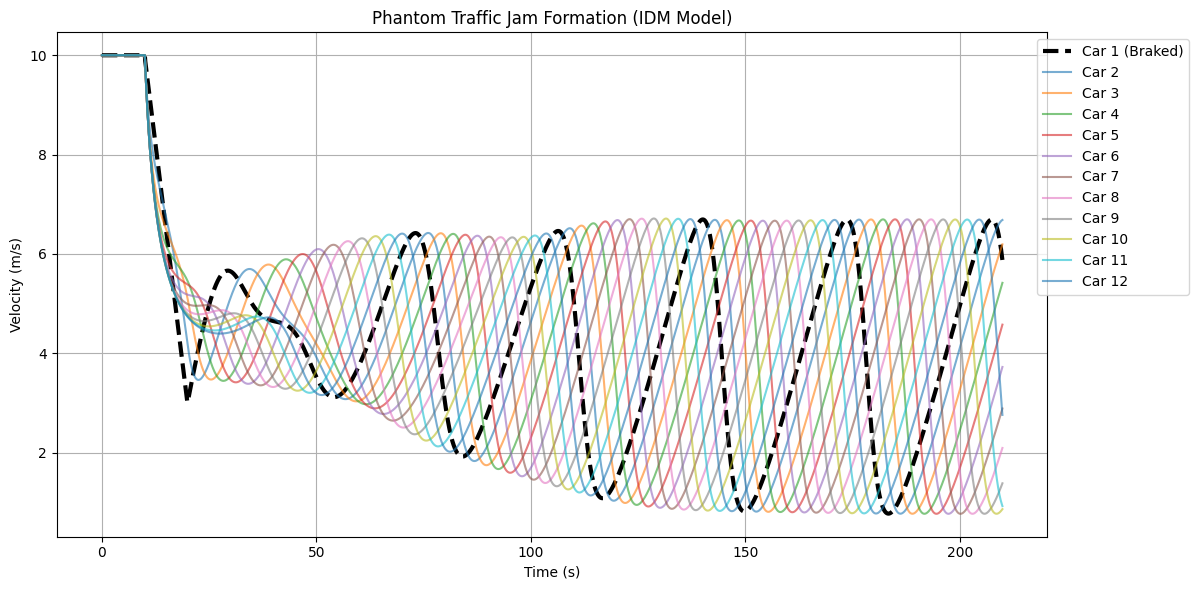

In [75]:
cars, road_length = run_simulate(12, 10, 200, 0.1)

plt.figure(figsize=(12, 6))
for car in cars:
    if car["id"] == 0:
        plt.plot(car["history_time"], car["history_vel"], label=f'Car {car["id"]+1} (Braked)', linewidth=3, color='black', linestyle='--')
    else:
        plt.plot(car["history_time"], car["history_vel"], label=f'Car {car["id"]+1}', alpha=0.6)
    
plt.title("Phantom Traffic Jam Formation (IDM Model)")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

In [76]:
# phantom_simulator = animate_combined_view(cars, road_length)
# Image(phantom_simulator)

## Improvements
- Implementing higher-order ODE solvers (like RK4) for improved accuracy.

In [79]:
def rk4_step(car, acc_func, h, max_velocity, road_length, front_car):
    v0 = car["velocity"]
    x0 = car["position"]
    
    def a(v, x):
        tmp_car = {"velocity": v, "position": x, "id": car["id"], "history_time": [], "history_vel": [], "history_pos": []}
        return acc_func(tmp_car, front_car, max_velocity, road_length)
    
    k1_v = a(v0, x0)
    k1_x = v0
    
    k2_v = a(v0 + 0.5*h*k1_v, x0 + 0.5*h*k1_x)
    k2_x = v0 + 0.5*h*k1_v
    
    k3_v = a(v0 + 0.5*h*k2_v, x0 + 0.5*h*k2_x)
    k3_x = v0 + 0.5*h*k2_v
    
    k4_v = a(v0 + h*k3_v, x0 + h*k3_x)
    k4_x = v0 + h*k3_v
    
    v_new = v0 + (h/6.0)*(k1_v + 2*k2_v + 2*k3_v + k4_v)
    x_new = x0 + (h/6.0)*(k1_x + 2*k2_x + 2*k3_x + k4_x)
    
    if v_new > max_velocity:
        v_new = max_velocity
    if v_new < 0:
        v_new = 0
    
    if x_new >= road_length:
        x_new -= road_length
    
    car["velocity"] = v_new
    car["position"] = x_new
    return car

In [80]:
def run_simulate_rk4(total_car, max_velocity, time_bound, h):
    cars = generate_car(total_car, max_velocity)
    road_length = total_car * 16
    steps = int(time_bound / h)
    current_time = 0.0
    
    # warm-up to log initial straight motion
    for _ in range(100):
        for car in cars:
            car["position"] += car["velocity"] * h
            if car["position"] >= road_length:
                car["position"] -= road_length
            log_car_state(car, current_time)
        current_time += h
    
    for _ in range(steps):
        for i in range(len(cars)):
            cur_car = cars[i]
            front_car = cars[(i - 1) % total_car]
            if cur_car["id"] == 0:
                front_car = cars[total_car - 1]
            
            # lead car manual slowdown event
            if (10 < current_time < 20 and cur_car["id"] == 0):
                cur_car["velocity"] -= 0.7 * h
                if cur_car["velocity"] < 0:
                    cur_car["velocity"] = 0
                cur_car["position"] += cur_car["velocity"] * h
                log_car_state(cur_car, current_time)
                continue
            
            log_car_state(cur_car, current_time)
            # RK4 step for coupled x', v' = v, a(x,v)
            cur_car = rk4_step(cur_car, get_idm_acceleration, h, max_velocity, road_length, front_car)
            
            if cur_car["position"] >= road_length:
                cur_car["position"] -= road_length
        current_time += h
    
    return cars, road_length

## Comparison of Euler vs RK4
- Euler is simple and fast but can be inaccurate for stiff systems or rapid changes. 
- RK4 provides better accuracy by considering slopes at multiple points within the time step, reducing numerical errors.

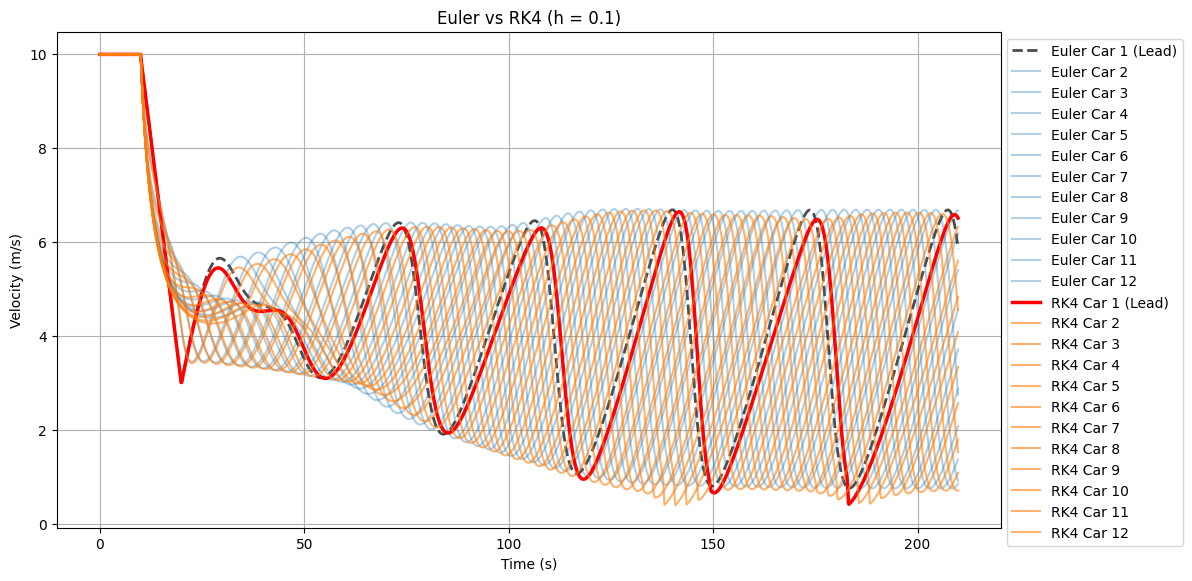

In [81]:
# Compare Euler vs RK4 at same h
cars_euler, road_len = run_simulate(12, 10, 200, 0.1)
cars_rk4, _ = run_simulate_rk4(12, 10, 200, 0.1)

plt.figure(figsize=(12, 6))
for car in cars_euler:
    if car["id"] == 0:
        plt.plot(car["history_time"], car["history_vel"], label=f'Euler Car {car["id"]+1} (Lead)', linewidth=2, color='black', linestyle='--', alpha=0.7)
    else:
        plt.plot(car["history_time"], car["history_vel"], label=f'Euler Car {car["id"]+1}', alpha=0.35, color='tab:blue')

for car in cars_rk4:
    if car["id"] == 0:
        plt.plot(car["history_time"], car["history_vel"], label=f'RK4 Car {car["id"]+1} (Lead)', linewidth=2.5, color='red')
    else:
        plt.plot(car["history_time"], car["history_vel"], label=f'RK4 Car {car["id"]+1}', alpha=0.6, color='tab:orange')

plt.title("Euler vs RK4 (h = 0.1)")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.tight_layout()
plt.show()